This is the baselines of some simple models using Monte Carlo methods

# OLS

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
# define function to run OLS with robust standard errors
def run_ols_robust(y, X_raw):
    X = pd.DataFrame(X_raw,columns=["x1", "x2"])
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit(cov_type="HC1")
    return model
# define Monte Carlo simulation function
def monte_carlo_simulation_ols(num_simulations=1000, n=200):
    results = []
    for _ in range(num_simulations):
        # Data generation
        x1 = np.random.normal(0, 1, n)
        x2 = np.random.normal(0, 1, n)
        u  = np.random.normal(0, 1, n)
        
        X_raw = np.column_stack((x1, x2))
        y = 4 + 3*x1 + 2*x2 + u
        
        # Run OLS with robust SE
        model = run_ols_robust(y, X_raw)
        results.append(model.params)
    
    return pd.DataFrame(results, columns=["const", "x1", "x2"])


In [45]:
#Single-run simulation experiment
# Data generation(DGP)
np.random.seed(42)
n = 200
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
u  = np.random.normal(0, 1, n)
X_raw = np.column_stack((x1, x2))
y = 4 + 3*x1 + 2*x2 + u
model = run_ols_robust(y, X_raw)
print(model.params)
print(model.summary())

const    3.910319
x1       2.858752
x2       1.979818
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1046.
Date:                Sat, 07 Feb 2026   Prob (F-statistic):          1.23e-105
Time:                        14:30:09   Log-Likelihood:                -280.23
No. Observations:                 200   AIC:                             566.5
Df Residuals:                     197   BIC:                             576.4
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [35]:
# Run Monte Carlo simulation
mc_results = monte_carlo_simulation_ols(num_simulations=1000, n=200)
print(mc_results.describe())

             const           x1           x2
count  1000.000000  1000.000000  1000.000000
mean      3.998572     2.998356     2.002427
std       0.070938     0.071734     0.072288
min       3.753536     2.774044     1.763959
25%       3.950081     2.950782     1.956312
50%       3.998010     2.997417     2.004147
75%       4.044827     3.048717     2.053350
max       4.222969     3.199052     2.226413


Bias: const   -0.001428
x1      -0.001644
x2       0.002427
dtype: float64
RMSE: const    0.070917
x1       0.071717
x2       0.072292
dtype: float64


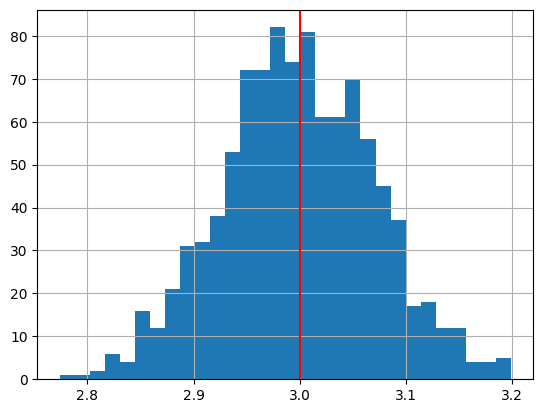

In [41]:
true = np.array([4, 3, 2])
bias = mc_results.mean() - true
rmse = np.sqrt(((mc_results - true)**2).mean())
print("Bias:", bias)
print("RMSE:", rmse)
mc_results["x1"].hist(bins=30)
plt.axvline(3, color="red")


The Monte Carlo results show that the OLS estimator is unbiased
and converges to the true parameter values as sample size increases.

# OLS with endogenous

In [63]:
def monte_carlo_ols_endogenous(num_simulations=1000, n=200, beta=3):
    results = []

    for _ in range(num_simulations):
        # Data generation
        beta = 0.9
        u  = np.random.normal(0, 1, n)
        x1 = np.random.normal(0, 1, n)
        z2 = np.random.normal(0, 1, n)

        x2 = z2 + beta*u  # x2 is endogenous, correlated with u
        
        X_raw = np.column_stack((x1, x2))
        y = 4 + 3*x1 + 2*x2 + u
        
        # Run OLS with robust SE
        model = run_ols_robust(y, X_raw)
        results.append(model.params)
    
    return pd.DataFrame(results, columns=["const", "x1", "x2"])

In [67]:
mc_endo_results = monte_carlo_ols_endogenous(num_simulations=1000, n=200)
print(mc_endo_results.describe())
true = np.array([4, 3, 2])
bias = mc_endo_results.mean() - true
rmse = np.sqrt(((mc_endo_results - true)**2).mean())
print("Bias:", bias)
print("RMSE:", rmse)


             const           x1           x2
count  1000.000000  1000.000000  1000.000000
mean      3.998280     2.998208     2.498691
std       0.051753     0.053588     0.039957
min       3.838072     2.851197     2.356874
25%       3.961827     2.962661     2.472498
50%       3.996930     2.997013     2.499022
75%       4.032140     3.034084     2.526332
max       4.178628     3.157755     2.622842
Bias: const   -0.001720
x1      -0.001792
x2       0.498691
dtype: float64
RMSE: const    0.051756
x1       0.053591
x2       0.500287
dtype: float64


Once endogeneity is introduced, OLS becomes systematically biased for the endogenous variable（x2=2.5）, and the bias does not disappear even with many simulations.

# Time series data-AR(1)

In [72]:
def monte_carlo_ols_ar1(num_simulations=1000, T=200, beta=2, rho=0.7):
    betas = []

    for _ in range(num_simulations):
        x = np.random.normal(0, 1, T)

        u = np.zeros(T)
        eps = np.random.normal(0, 1, T)
        for t in range(1, T):
            u[t] = rho * u[t-1] + eps[t]

        y = beta * x + u

        X = sm.add_constant(x)
        model= sm.OLS(y, X).fit()
        betas.append(model.params[1])

    return np.array(betas)


In [73]:
# Run AR(1) Monte Carlo simulation
ar1_results = monte_carlo_ols_ar1(num_simulations=1000, T=200, beta=2, rho=0.7)
print("AR(1) OLS Coefficient Estimates:")
print(pd.Series(ar1_results).describe())


AR(1) OLS Coefficient Estimates:
count    1000.000000
mean        1.995387
std         0.097897
min         1.621537
25%         1.928228
50%         1.998060
75%         2.058349
max         2.324552
dtype: float64
